# Кредитовый скоринг на Kaggle

In [6]:
from pandas import Series
import pandas as pd
import numpy as np
import math


import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

In [2]:
data = pd.read_csv('train_scoring_kaggle.csv')
test = pd.read_csv('test_scoring_kaggle.csv')
data.head(2)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0





    client_id - идентификатор клиента

    education - уровень образования

    sex - пол заемщика

    age - возраст заемщика

    car - флаг наличия автомобиля

    car_type - флаг автомобиля иномарки

    decline_app_cnt - количество отказанных прошлых заявок

    good_work - флаг наличия “хорошей” работы

    bki_request_cnt - количество запросов в БКИ

    home_address - категоризатор домашнего адреса

    work_address - категоризатор рабочего адреса

    income - доход заемщика

    foreign_passport - наличие загранпаспорта

    sna - связь заемщика с клиентами банка

    first_time - давность наличия информации о заемщике

    score_bki - скоринговый балл по данным из БКИ

    region_rating - рейтинг региона

    app_date - дата подачи заявки

    default - флаг дефолта по кредиту




In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [4]:
data.isnull().sum()

client_id             0
app_date              0
education           307
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
default               0
dtype: int64

<AxesSubplot:>

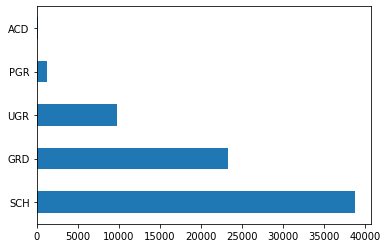

In [8]:
data.education.value_counts().plot.barh()

Text(0.5, 0, '1 - дефолт, 0 - выдача')

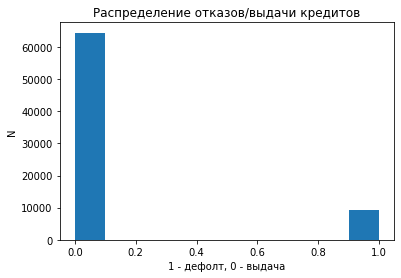

In [6]:
fig, ax = plt.subplots()
ax.hist(data.default)
ax.set_title('Распределение отказов/выдачи кредитов')

ax.set_ylabel('N')
ax.set_xlabel('1 - дефолт, 0 - выдача')

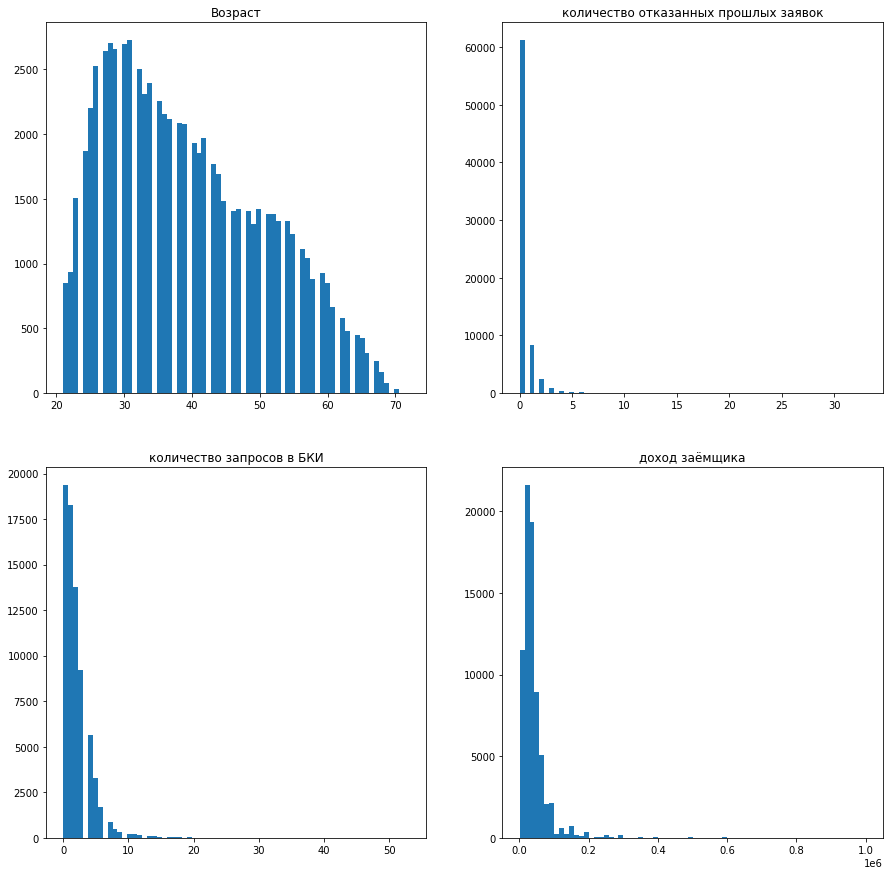

In [3]:
def plot_scoring():
    fig, axes = plt.subplots(2,2,figsize=(15,15))
    axes[0,0].hist(data['age'],bins = 70)
    axes[0,0].set_title('Возраст')

    axes[0,1].hist(data['decline_app_cnt'],bins = 70)
    axes[0,1].set_title('количество отказанных прошлых заявок')

    axes[1,0].hist(data['bki_request_cnt'],bins = 70)
    axes[1,0].set_title('количество запросов в БКИ')

    axes[1,1].hist(data['income'],bins = 70)
    axes[1,1].set_title('доход заёмщика')
plot_scoring()

In [4]:
def corr_education(path, p):
    if p==0:
        mas = pd.read_csv('train_scoring_kaggle.csv')
    else:
        mas = pd.read_csv('test_scoring_kaggle.csv')
    if path == 1:
        mas.education = mas.education.apply(lambda x:'other' if x!=x else x)
    elif path == 2:
        mas.education = mas.education.apply(lambda x:'SCH' if x!=x else x)
    elif path == 3:
        mas.dropna(inplace = True)
    elif path ==0:
        print('Full data, where in education 307 nan')
    return mas
data = corr_education(1,0)
test = corr_education(1,1)
data.education.value_counts()

SCH      38860
GRD      23365
UGR       9816
PGR       1257
other      307
ACD        194
Name: education, dtype: int64

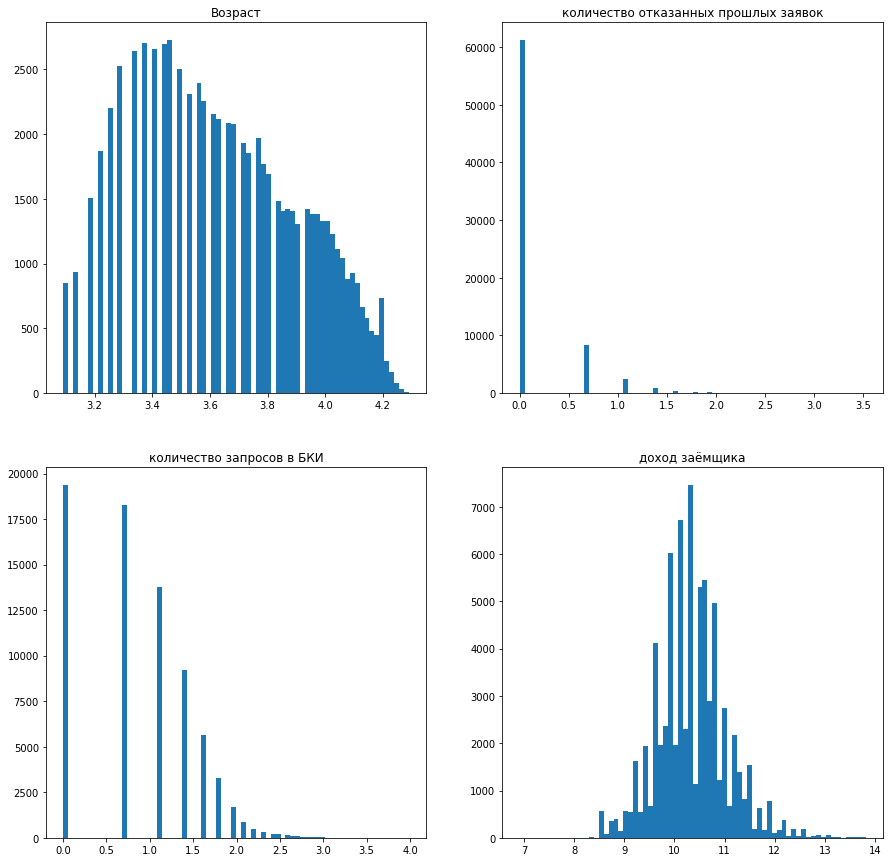

In [8]:
def log_data():
    #num_set = ['score_bki','age','decline_app_cnt','bki_request_cnt','income'] 
    list_ = ['age','decline_app_cnt','bki_request_cnt','income']
    for i in list_:
        data[i] = data[i].apply(lambda x: math.log1p(x))
        test[i] = test[i].apply(lambda x: math.log1p(x))
    plot_scoring()
log_data()

# Временной формат

In [9]:
data.app_date = pd.to_datetime(data.app_date)
data['month'] = data.app_date.dt.month
data['weekend'] = data.app_date.dt.dayofweek.apply(lambda x: 1 if x >=5 else 0)

test.app_date = pd.to_datetime(test.app_date)
test['month'] = test.app_date.dt.month
test['weekend'] = test.app_date.dt.dayofweek.apply(lambda x: 1 if x >=5 else 0)


## Какие данные у нас есть?

In [15]:
bin_set = ['weekend','sex','car','car_type','good_work','foreign_passport']
num_set = ['score_bki','age','decline_app_cnt','bki_request_cnt','income'] 
cat_set = ['month','region_rating','first_time','sna','education','home_address','work_address'] 

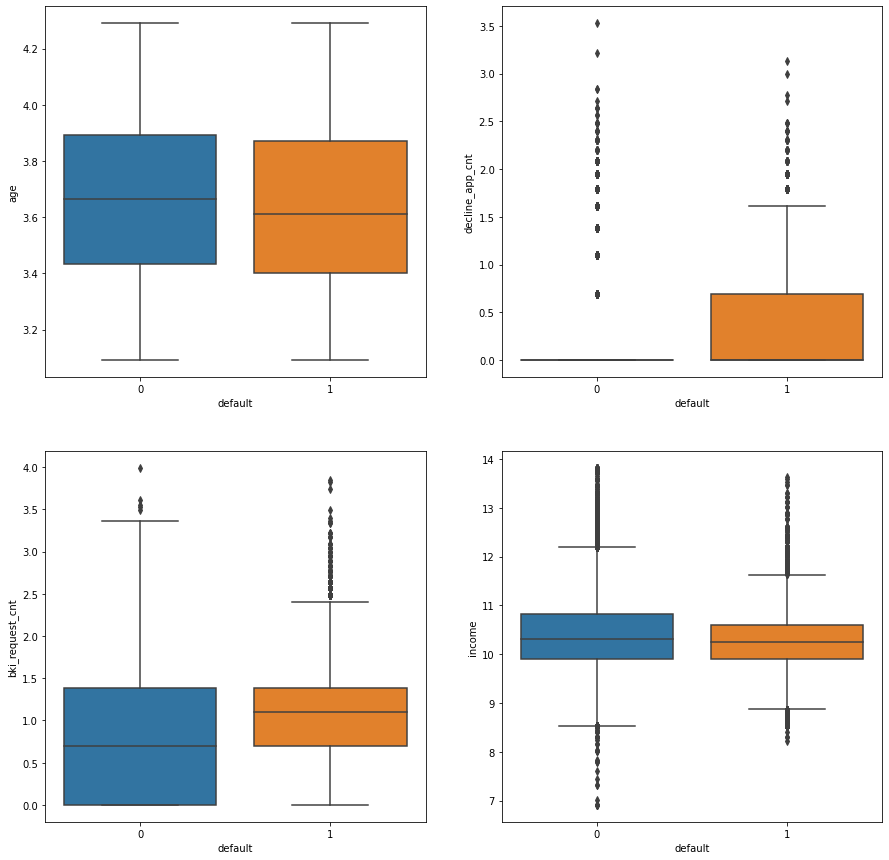

In [6]:
def box_plot_default_client():
    fig, axes = plt.subplots(2,2,figsize=(15,15))
    sns.boxplot(x =data['default'], y = data['age'],ax =axes[0,0])
    sns.boxplot(x =data['default'], y = data['decline_app_cnt'],ax =axes[0,1])
    sns.boxplot(x =data['default'], y = data['bki_request_cnt'],ax =axes[1,0])
    sns.boxplot(x =data['default'], y = data['income'],ax =axes[1,1])
box_plot_default_client()

# Если между признаками есть корреляция это плохо
1. корреляция Пирсона - оставить низко креллированные признаки
2. регуляризация - штраф за сложность модели

$$r_{xy}=\frac{\sum(x_{i}-\bar{x})\times(y_{i}-\bar{y})}{\sqrt{\sum(x_{i}-\bar{x})^2\times\sum(y_{i}-\bar{y})^2}}$$

<AxesSubplot:>

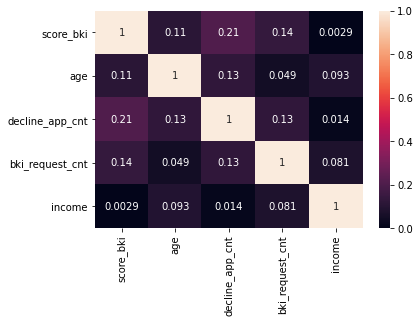

In [28]:
sns.heatmap(data[num_set].corr().abs(), vmin=0, vmax=1,annot = True)

# Статистическая проверка значимости признаков. 
Рассмотрим аналог критерия Т - Стьдента (проверка равенства средних в двух выборках, при нормальном распределение, иначе критерий Мана Уитни например)
Другой критерий это критерий $ANOVA$ (дисперсионный анализ). Очевидное отличие в том, что критерий Т - Стьюдента для парного сравнения, а у нас больше чем две пары, соотвественно чтобы использовать Т критерий нужно будет перебрать все пары( если прихнаков много, то это будет затратно)

**Условия применения дисперсионного анализа ANOVA**
https://kpfu.ru/portal/docs/F468481519/Lekciya.3.pdf

Перед тем как приступить к применению дисперсионного анализа, который предназначен для минимизации риска неправильной оценки ошибки 1 рода в случае множественных сравнений необходимо убедиться в соблюдении ряда условий:

    Количественный непрерывный тип данных, дискретные данные менее желательны.
    Независимые между собой выборки.
    Нормальное распределение признака в статистических совокупностях, из которых извлечены выборки.
    Равенство (гомогенность) дисперсий изучаемого признака в статистических совокупностях из которых извлечены выборки, проверяется с помощью критерия Levene.
    Независимые наблюдения в каждой из выборок.

Для однофакторного критерия anova используется статиска F (фишера), которую и будем использовать. Чем значение статистики выше, тем меньше вероятность того, что средние значения не отличаются, и тем важнее данный признак для нашей линейной модели.

<AxesSubplot:>

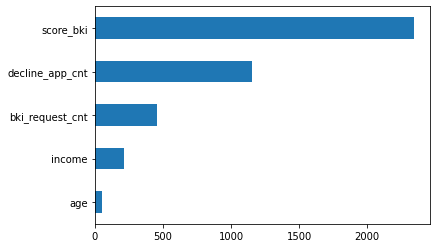

In [11]:
imp_num = pd.Series(f_classif(data[num_set], data['default'])[0], index = num_set)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

# Преобразование бинарных данных -LabelEncoding
Самый простой способ — отобразить каждое значение категории в уникальное число. Например, в поле sex значение sex = female преобразовать в , а sex = male — в . Эту простую операцию приходится делать достаточно часто, поэтому в модуле sklearn.preprocessing именно для этой задачи реализован класс LabelEncoder.

Метод fit этого класса находит все уникальные значения и строит таблицу для соответствия каждой категории некоторому числу, а метод transform непосредственно преобразует значения в числа. После fit у label_encoder будет доступно поле classes_, содержащее все уникальные значения. Можно их пронумеровать и убедиться, что преобразование выполнено верно.

In [31]:
label_encoder = LabelEncoder()

mapped_education = pd.Series(label_encoder.fit_transform(data['sex']))
print(dict(enumerate(label_encoder.classes_)))


{0: 'F', 1: 'M'}


In [12]:
# Для бинарных признаков мы будем использовать LabelEncoder
label_encoder = LabelEncoder()

for column in bin_set:
    data[column] = label_encoder.fit_transform(data[column])
    test[column] = label_encoder.fit_transform(test[column])
# убедимся в преобразовании    
data.head()



,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,month,weekend
0,25905,2014-02-01,SCH,1,4.143135,1,1,0.000000,0,-2.008753,...,50,1,2,9.798183,4,1,0,0,2,1
1,63161,2014-03-12,SCH,0,4.094345,0,0,0.000000,0,-1.532276,...,50,2,3,9.852247,4,1,0,0,3,0
2,25887,2014-02-01,SCH,1,3.258097,1,0,1.098612,0,-1.408142,...,80,1,2,10.308986,1,4,1,0,2,1
3,16222,2014-01-23,SCH,0,3.988984,0,0,0.000000,0,-2.057471,...,50,2,3,9.210440,1,3,0,0,1,0
4,101655,2014-04-18,GRD,1,3.891820,0,0,0.000000,1,-1.244723,...,60,2,3,10.308986,1,4,1,0,4,0


Почему мы применили метод только к бинарным переменным? Единственным минусом использования кодирования при помощи LabelEncoder() является то, что при использовании этого подхода мы должны быть уверены, что признак не может принимать неизвестных ранее значений. 

→ Что произойдет, если у нас появятся данные с другими категориями? LabelEncoder будет ругаться, что не знает новую категорию. 

Например, если у нас появится новый пол (помимо женского и мужского), признак sex придется обрабатывать по-другому.

Исходя из описания, наши признаки строго бинарные (принимают только два значения) и сюрпризов (новых неизвестных значений) быть не должно

# Значимость категориальных признаков

Для оценки значимости категориальных и бинарных переменных будем использовать функцию mutual_info_classif из библиотеки sklearn. Данная функция опирается на непараметрические методы, основанные на оценке энтропии в группах категориальных переменных.

In [18]:
# Обработаем признак education
index_education = data.education.value_counts().index.to_list()
def trans(name):
    if name in index_education:
        return index_education.index(name)
    else:
        print('У вас пропущенное значение в датафрэйме')
data.education = data.education.apply(trans)
data.education.value_counts()

test.education = test.education.apply(trans)


<AxesSubplot:>

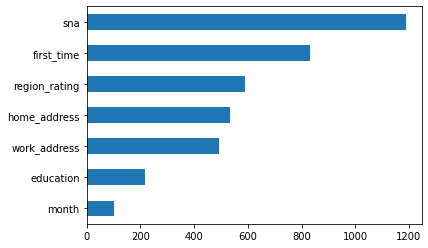

In [20]:
# Важность по ANOVA
imp_num = pd.Series(f_classif(data[cat_set], data['default'])[0], index = cat_set)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

### Совместная проверка важности бинарных и категориальных данных 
**mutual_info_classif**

<AxesSubplot:>

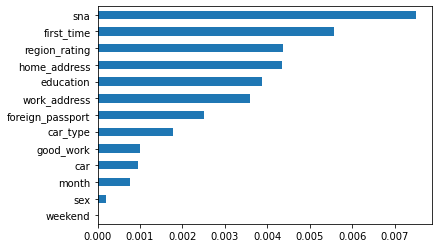

In [21]:

imp_cat = Series(mutual_info_classif(data[bin_set + cat_set], data['default'],
                                     discrete_features =True), index = bin_set + cat_set)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

# Подготовка данных к машинному обучению
Категориальные данные нужно кодировать более особым способом
Если dymmy, то это будет так (допустим 3 подтипа данных), то образуем три столбца и заполняем нулями или единицами
Если у нас бинарные данные то $LabelEncoding$ : да 0, нет  1 или наоборот ..тут всего два выбора, а вот в категориальных их может быть больше. И тут применяют что то типа $One-Hot Encoding$. Предположим, что некоторый признак может принимать пять разных значений. В этом случае $One Hot Encoding$ подразумевает создание пяти новых признаков, все из которых равны нулю, за исключением одного. На позицию, соответствующую численному значению признака, мы помещаем 1. Эта техника реализована в sklearn.preprocessing в классе OneHotEncoder. По умолчанию OneHotEncoder преобразует данные в разреженную матрицу, чтобы не расходовать память на хранение многочисленных нулей.

In [22]:
X_cat = OneHotEncoder(sparse = False).fit_transform(data[cat_set].values)
# датафрэйм нужно преобразовать в массив numpy
# sparse(default =True) Will return sparse matrix if set True else will return an array.

X_test_cat = OneHotEncoder(sparse = False).fit_transform(test[cat_set].values)


In [39]:
X_cat.shape
# 12 новых переменных вместо 3-х категориальных

(73799, 31)

# Нормализация данных для непрерывных значений

In [23]:
X_num = StandardScaler().fit_transform(data[num_set].values)
X_test_num = StandardScaler().fit_transform(test[num_set].values)


# Объединяем данные

In [26]:

X = np.hstack([X_num, data[bin_set].values, X_cat])
Y = data['default'].values

X_test_kaggle = np.hstack([X_test_num, test[bin_set].values, X_test_cat])


# Разделение на обучающую и валидационную выборку

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

# Логистическая регрессия

In [30]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
confusion_matrix(y_test, y_pred)

/home/arthur/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


array([[12869,    64],
       [ 1782,    45]])

# Оценка качества


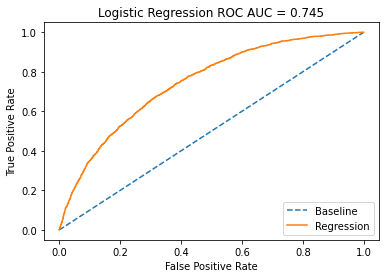

In [31]:
probs = model.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

# Регуляризация

In [32]:
from sklearn.model_selection import GridSearchCV

# Добавим типы регуляризации
penalty = ['l1', 'l2']


# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)
# 10 значений от 0 до 4 равномерно распредленных по логарифмической шкале

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression()
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])


/home/arthur/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/arthur/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/arthur/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/arthur/.local/lib/

/home/arthur/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/arthur/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/arthur/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/arthur/.local/lib/

/home/arthur/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/arthur/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/arthur/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/arthur/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/home/arthur/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to conver

Лучшее Penalty: l2
Лучшее C: 2.7825594022071245


/home/arthur/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


/home/arthur/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


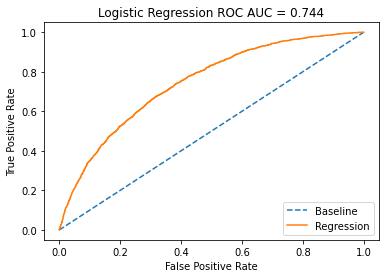

In [33]:
C_reg = best_model.best_estimator_.get_params()['C']
model = LogisticRegression(C=C_reg)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

probs = model.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()